In [130]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyscipopt import Model, quicksum
from tabulate import tabulate

In [75]:
M = 10
NumExpert = 3

In [76]:
rnd = np.random.RandomState(1)

In [77]:
matrix = rnd.normal(10, 1, size=(M, 3))

In [78]:
a_prim = np.zeros((NumExpert,M,M))
for k in range(NumExpert):
    for i in range(M):
        for j in range(M):
            if matrix[i,k] < matrix[j,k]:
                a_prim[k,i,j] = 0
            else:
                a_prim[k,i,j] = 1

In [79]:
a = np.round(a_prim + rnd.normal(0, 0.1, (NumExpert,M,M)),2)

In [138]:
a[ a < 0.00001 ] = 0.0
a[ a > 0.99999 ] = 1.0
for k in range(NumExpert):
    for i in range(M):
        a[k,i,i] = 1
    print(f"k = {k}")
    print(tabulate(a[k], numalign="right"), "\n")

k = 0
----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   1  0.96     0  0.92  0.93     1  0.89     1     1     1
   0     1     0  0.17  0.01  0.94  0.02  0.21  0.01  0.06
   1  0.96     1  0.97  0.98     1     1     1     1     1
   0     1  0.05     1     1  0.99  0.11  0.15  0.22  0.86
   0  0.95  0.02  0.09     1   0.8     0  0.08  0.02     1
   0     0  0.02  0.04  0.02     1     0  0.04  0.01  0.11
0.12     1     0  0.94     1     1     1     0     0     1
   0     1  0.04     1  0.89     1     1     1  0.97     1
   0     1  0.08  0.91     1  0.87     1     0     1     1
   0  0.92  0.13   0.2     0     1  0.16  0.03     0     1
----  ----  ----  ----  ----  ----  ----  ----  ----  ---- 

k = 1
----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   1     0  0.88  0.06  0.08     0  0.05     0     1     0
0.98     1     1  0.08     1     1     1  0.06     1     1
   0     0     1  0.22  0.04     0     0     0     0     0
0.95   0.9     1     1     1  0.98     1  

In [81]:
def kemeny_matrix(a):
    w = np.zeros((M,M))
    for k in range(NumExpert):
        for i in range(M):
            for j in range(M):
                if a[k,j,i] > 0 and i != j:
                    w[i,j] += 1
    model = Model() 
    model.hideOutput(True)
    x = {}
    for i in range(M):
        for j in range(M):
            if i != j:
                x[(i,j)] = model.addVar(f"x[{i},{j}]", vtype = 'B')
    for l in range(M):
        for i in range(M):
            for j in range(M):
                if i != j and j != l and i != l:
                    model.addCons(x[(i,j)] + x[(j,l)] + x[(l,i)] >= 1)
    for i in range(M):
        for j in range(M):
            if i != j:
                model.addCons(x[(i,j)] + x[(j,i)] == 1)
    model.setObjective(quicksum(w[i,j] * x[(i,j)] for i in range(M) for j in range(M) if i != j), "minimize")
    model.optimize()
    sol = model.getBestSol()
    if model.getStatus() != 'optimal':
        print(f"Ops! {model.getStatus()}")
        return np.zeros((M,M))
    # model.getSolvingTime()
    return np.array([[ int(sol[x[(i,j)]]) if i != j else 1 for j in range(M)] for i in range(M)])

In [119]:
kms = []
tetas = []
for teta in np.arange(0.1,1.1,0.1):
    tetas.append(teta)
    a_teta = np.array(a)
    a_teta[a_teta >= teta] = 1
    a_teta[a_teta < 1] = 0
    mykm = kemeny_matrix(a_teta)
    kms.append(mykm)

In [120]:
for i in range(len(kms)-1):
    print(i, np.where(kms[i] != kms[i+1]))

0 (array([], dtype=int64), array([], dtype=int64))
1 (array([], dtype=int64), array([], dtype=int64))
2 (array([], dtype=int64), array([], dtype=int64))
3 (array([], dtype=int64), array([], dtype=int64))
4 (array([], dtype=int64), array([], dtype=int64))
5 (array([], dtype=int64), array([], dtype=int64))
6 (array([], dtype=int64), array([], dtype=int64))
7 (array([0, 2, 4, 6, 6, 6, 6, 6, 8, 9]), array([6, 6, 6, 0, 2, 4, 8, 9, 6, 6]))
8 (array([0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 8, 8, 8, 9, 9, 9, 9, 9]), array([6, 7, 9, 6, 9, 6, 7, 9, 6, 7, 8, 9, 6, 7, 0, 1, 2, 3, 4, 8, 0, 2,
       3, 4, 3, 6, 9, 0, 1, 2, 3, 8]))


In [129]:
print("i=\t","\t".join(map(str, np.where(kms[7] != kms[8])[0])))
print("j=\t","\t".join(map(str, np.where(kms[7] != kms[8])[1])))
for i in range(len(kms)):
    print(np.round(tetas[i],2),"\t", "\t".join(map(str, kms[i][np.where(kms[7] != kms[8])])))

i=	 0	2	4	6	6	6	6	6	8	9
j=	 6	6	6	0	2	4	8	9	6	6
0.1 	 1	1	1	0	0	0	0	0	1	1
0.2 	 1	1	1	0	0	0	0	0	1	1
0.3 	 1	1	1	0	0	0	0	0	1	1
0.4 	 1	1	1	0	0	0	0	0	1	1
0.5 	 1	1	1	0	0	0	0	0	1	1
0.6 	 1	1	1	0	0	0	0	0	1	1
0.7 	 1	1	1	0	0	0	0	0	1	1
0.8 	 1	1	1	0	0	0	0	0	1	1
0.9 	 0	0	0	1	1	1	1	1	0	0
1.0 	 1	1	1	0	0	0	0	1	1	0


In [90]:
kms_prim = kemeny_matrix(a_prim)

In [152]:
for i in range(len(kms)-1):
    print(i, round(tetas[i],2),round(tetas[i+1],2),len(np.where(kms[i] != kms[i+1])[0]))

0 0.1 0.2 0
1 0.2 0.3 0
2 0.3 0.4 0
3 0.4 0.5 0
4 0.5 0.6 0
5 0.6 0.7 0
6 0.7 0.8 10
7 0.8 0.9 10
8 0.9 1.0 32


In [153]:
for i in range(len(kms)):
    print(i, round(tetas[i],2), np.sum(np.abs(kms_prim - kms[i])))

0 0.1 0
1 0.2 0
2 0.3 0
3 0.4 0
4 0.5 0
5 0.6 0
6 0.7 0
7 0.8 10
8 0.9 20
9 1.0 36


0.8 True
0.9 True
1.0 True


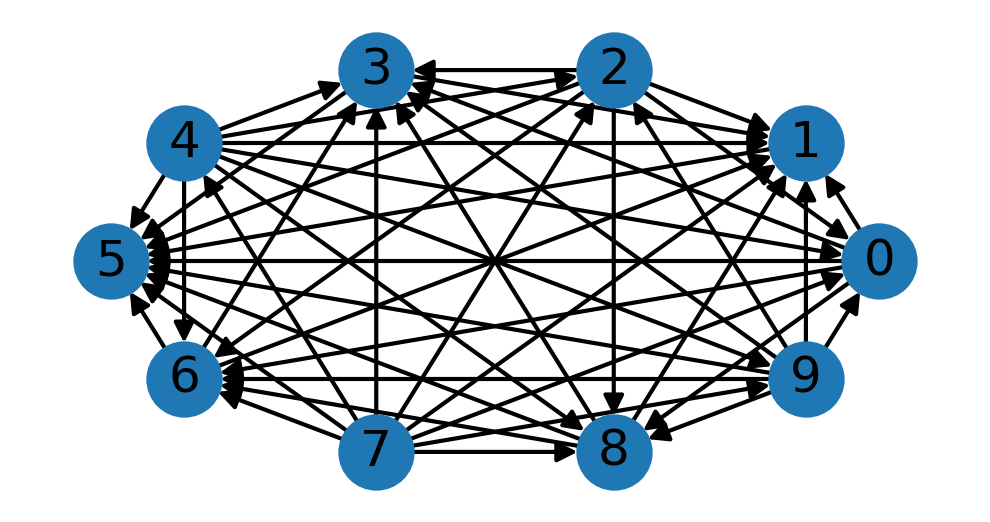

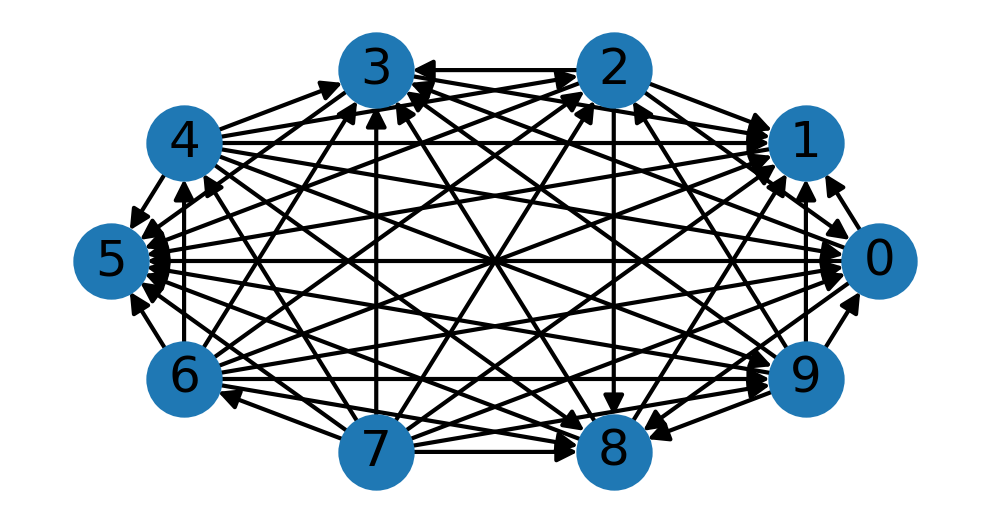

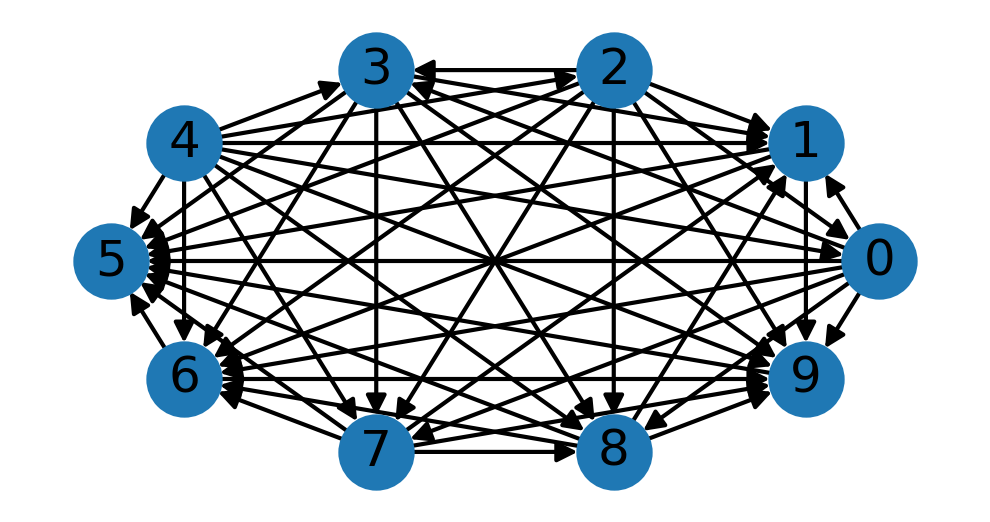

In [147]:
for j in [7, 8, 9]:
    for i in range(M):
        kms[j][i,i] = 0
    G = nx.from_numpy_array(kms[j], create_using = nx.DiGraph())
    print(np.round(tetas[j],2), nx.is_directed_acyclic_graph(G))
    fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
    nx.draw(G,with_labels=True, pos = nx.circular_layout(G))
    plt.savefig(f"fig_new_{j}.png", format="PNG")

In [148]:
res_fuzzy_matrix = np.eye(M,M)
for i in range(M):
    for j in range(M):
        if i !=j:
            ind = np.nonzero(np.fromiter((kms[k][i,j] for k in range(len(tetas))), int))[0]
            if len(ind) > 0:
                res_fuzzy_matrix[i,j] = tetas[np.max(ind)]

In [149]:
res_fuzzy_matrix

array([[1. , 1. , 0. , 1. , 0. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 1. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 1. ],
       [1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 1. , 0. , 1. , 0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0.9, 0.9, 0.9, 0.9, 0.9, 1. , 1. , 0. , 0.9, 1. ],
       [0.9, 1. , 0.9, 0.9, 0.9, 1. , 1. , 1. , 1. , 1. ],
       [0. , 1. , 0. , 0.9, 0. , 1. , 1. , 0. , 1. , 1. ],
       [0.9, 0.9, 0.9, 0.9, 0. , 1. , 0.8, 0. , 0.9, 1. ]])

In [150]:
np.fromiter((kms[k][0,9] for k in range(len(tetas))), int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [151]:
np.fromiter((kms[k][9,0] for k in range(len(tetas))), int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])